In [1]:
import pandas as pd
import numpy as np

#Imports para visualizacao de dados
import matplotlib.pylab as plt
import seaborn as sns

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera

from sklearn.metrics import mean_squared_error


# Imports para análise de dados
import scipy
from scipy.stats import boxcox

import warnings
warnings.filterwarnings("ignore")

In [2]:
dfRaw = pd.read_csv('dados/Electric_Production.csv')
dfRaw.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
dfRaw.rename(columns={'DATE':'data','IPG2211A2N':'Producao'}, inplace=True)
dfRaw['data'] = pd.to_datetime(dfRaw['data'], format='%m/%d/%Y')
dfRaw.set_index('data',inplace=True)
print(dfRaw.index.min())
print(dfRaw.index.max())

1985-01-01 00:00:00
2018-01-01 00:00:00


In [4]:
dfRaw.head()

,Producao
data,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
dfRaw.shape

(397, 1)

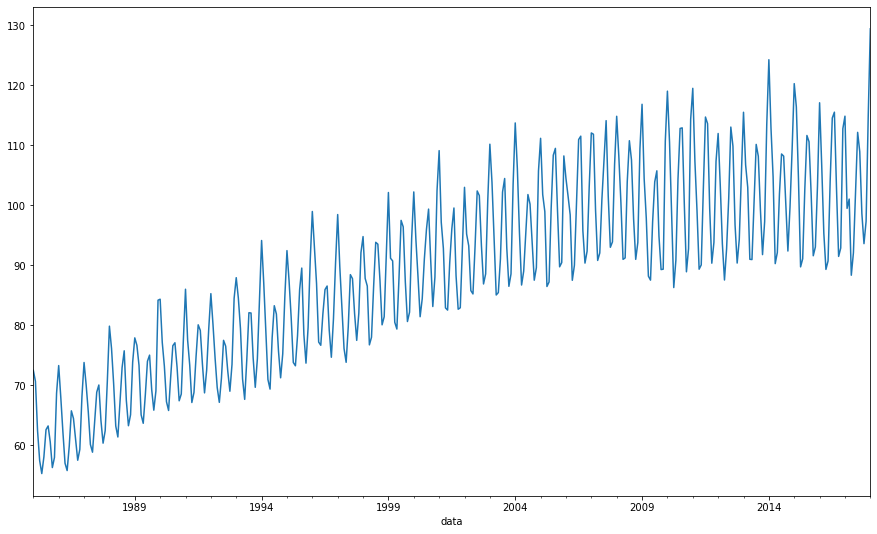

In [6]:
plt.figure(figsize=(15,9))
dfRaw.Producao.plot()
plt.show()

In [7]:
dfTimeSerie = dfRaw.copy()
dfTimeSerie['Media'] = dfRaw['Producao'].rolling(window=12).mean()
dfTimeSerie['Desvio'] = dfRaw['Producao'].rolling(window=12).std()

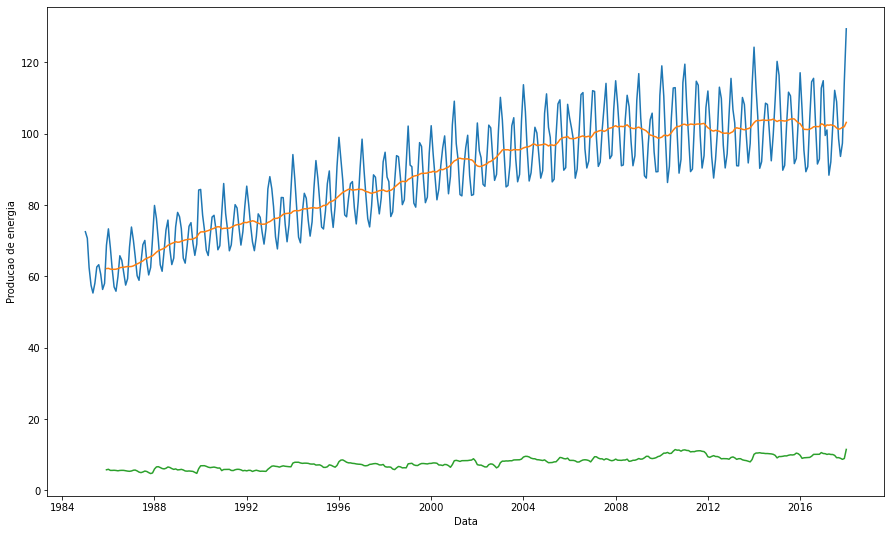

In [8]:
plt.figure(figsize=(15,9))
plt.plot(dfTimeSerie.Producao)
plt.plot(dfTimeSerie.Media)
plt.plot(dfTimeSerie.Desvio)
plt.ylabel('Producao de energia')
plt.xlabel('Data')
plt.show()

In [9]:
serieMediaMensal = dfTimeSerie['Media'].resample('MS').mean().dropna()

In [10]:
decomposed = seasonal_decompose(serieMediaMensal, period=12)

seasonal = decomposed.seasonal 
trend = decomposed.trend 
resid = decomposed.resid
observed = decomposed.observed

<Figure size 864x576 with 0 Axes>

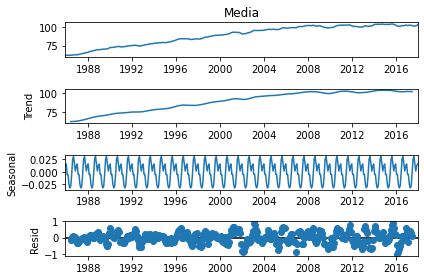

In [11]:
decomposed = seasonal_decompose(serieMediaMensal, period=12)

plt.figure(figsize=(12,8))
decomposed.plot()
plt.show()

In [12]:
def testaEstacionariedade(serie):
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

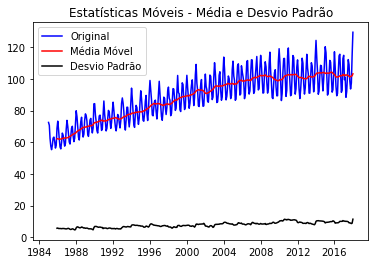


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.256990
Valor-p                           0.186215
Número de Lags Consideradas      15.000000
Número de Observações Usadas    381.000000
Valor Crítico (1%)               -3.447631
Valor Crítico (5%)               -2.869156
Valor Crítico (10%)              -2.570827
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [13]:
testaEstacionariedade(dfTimeSerie["Producao"])

In [14]:
dfTimeSerie.head()

,Producao,Media,Desvio
data,,,
1985-01-01,72.5052,NaN,NaN
1985-02-01,70.6720,NaN,NaN
1985-03-01,62.4502,NaN,NaN
1985-04-01,57.4714,NaN,NaN
1985-05-01,55.3151,NaN,NaN


In [15]:
xt, _ = boxcox(dfTimeSerie["Producao"])
dfTimeSerie["boxcox"] = xt
dfTimeSerie.head()

,Producao,Media,Desvio,boxcox
data,,,,
1985-01-01,72.5052,NaN,NaN,92.019399
1985-02-01,70.6720,NaN,NaN,89.495821
1985-03-01,62.4502,NaN,NaN,78.239699
1985-04-01,57.4714,NaN,NaN,71.476331
1985-05-01,55.3151,NaN,NaN,68.560510


<AxesSubplot:ylabel='Frequency'>

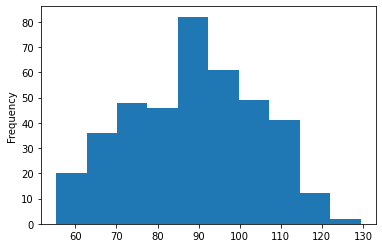

In [16]:
dfTimeSerie.Producao.plot.hist()

<AxesSubplot:ylabel='Frequency'>

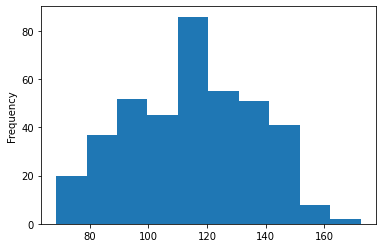

In [17]:
dfTimeSerie.boxcox.plot.hist()

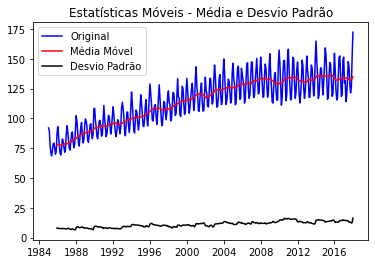


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.195666
Valor-p                           0.207822
Número de Lags Consideradas      15.000000
Número de Observações Usadas    381.000000
Valor Crítico (1%)               -3.447631
Valor Crítico (5%)               -2.869156
Valor Crítico (10%)              -2.570827
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [18]:
testaEstacionariedade(dfTimeSerie['boxcox'])

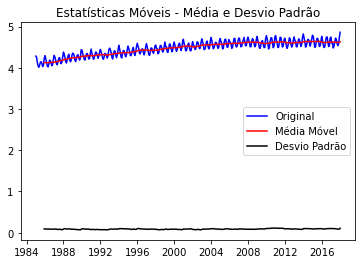


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -3.145360
Valor-p                           0.023373
Número de Lags Consideradas      15.000000
Número de Observações Usadas    381.000000
Valor Crítico (1%)               -3.447631
Valor Crítico (5%)               -2.869156
Valor Crítico (10%)              -2.570827
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [19]:
dfTimeSerie["log"]= np.log(dfTimeSerie.Producao)
testaEstacionariedade(dfTimeSerie.log)

In [20]:
dfTimeSerie['logRolling'] = dfTimeSerie['log'].rolling(window=12).mean().dropna()

In [21]:
dfTimeSerie.head()

,Producao,Media,Desvio,boxcox,log,logRolling
data,,,,,,
1985-01-01,72.5052,NaN,NaN,92.019399,4.283658,NaN
1985-02-01,70.6720,NaN,NaN,89.495821,4.258049,NaN
1985-03-01,62.4502,NaN,NaN,78.239699,4.134369,NaN
1985-04-01,57.4714,NaN,NaN,71.476331,4.051287,NaN
1985-05-01,55.3151,NaN,NaN,68.560510,4.013046,NaN


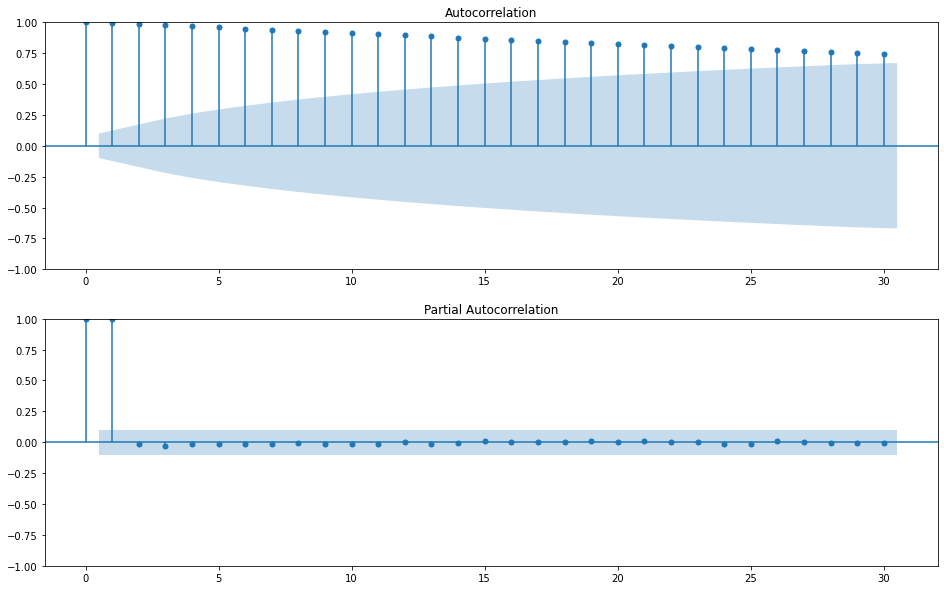

In [22]:
plt.rcParams.update({'figure.figsize': (16,10)})

plt.subplot(211)
tsaplots.plot_acf(dfTimeSerie["logRolling"].dropna(), ax = plt.gca(), lags = 30)

plt.subplot(212)
tsaplots.plot_pacf(dfTimeSerie['logRolling'].dropna(), ax = plt.gca(), lags = 30)
plt.show()

In [23]:
dfTimeSerie['logRollingDiff'] = dfTimeSerie['logRolling']-dfTimeSerie['logRolling'].shift(1)
dfTimeSerie.head()

,Producao,Media,Desvio,boxcox,log,logRolling,logRollingDiff
data,,,,,,,
1985-01-01,72.5052,NaN,NaN,92.019399,4.283658,NaN,NaN
1985-02-01,70.6720,NaN,NaN,89.495821,4.258049,NaN,NaN
1985-03-01,62.4502,NaN,NaN,78.239699,4.134369,NaN,NaN
1985-04-01,57.4714,NaN,NaN,71.476331,4.051287,NaN,NaN
1985-05-01,55.3151,NaN,NaN,68.560510,4.013046,NaN,NaN


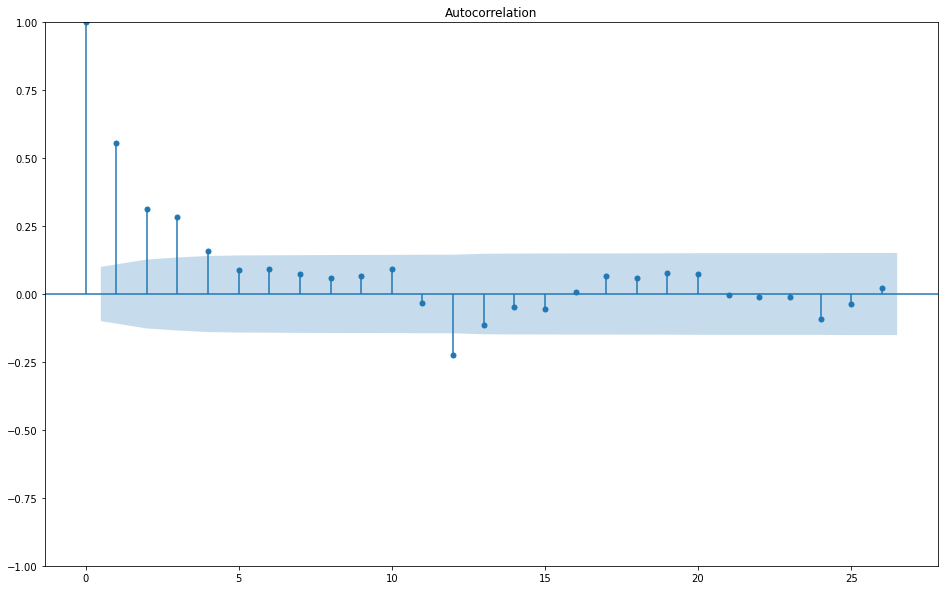

In [24]:
tsaplots.plot_acf(dfTimeSerie['logRollingDiff'].dropna());

In [25]:
#Divisao em treino e teste

idxTrain = int(dfTimeSerie.shape[0]*0.75)
idxTrain
train = dfTimeSerie.iloc[0:idxTrain]
test = dfTimeSerie.iloc[idxTrain:]

In [26]:
train.head()

,Producao,Media,Desvio,boxcox,log,logRolling,logRollingDiff
data,,,,,,,
1985-01-01,72.5052,NaN,NaN,92.019399,4.283658,NaN,NaN
1985-02-01,70.6720,NaN,NaN,89.495821,4.258049,NaN,NaN
1985-03-01,62.4502,NaN,NaN,78.239699,4.134369,NaN,NaN
1985-04-01,57.4714,NaN,NaN,71.476331,4.051287,NaN,NaN
1985-05-01,55.3151,NaN,NaN,68.560510,4.013046,NaN,NaN


In [27]:
test.head()

,Producao,Media,Desvio,boxcox,log,logRolling,logRollingDiff
data,,,,,,,
2009-10-01,89.2977,99.095192,9.125841,115.345570,4.491976,4.592254,-0.001572
2009-11-01,89.3585,98.724592,9.444897,115.430665,4.492656,4.588207,-0.004047
2009-12-01,110.6844,98.829783,9.580921,145.527966,4.706683,4.589163,0.000956
2010-01-01,119.0166,99.011867,9.967122,157.410895,4.779263,4.590707,0.001544
2010-02-01,110.5330,99.521267,10.414812,145.312652,4.705314,4.595448,0.004741


In [28]:
modelAR = ARIMA(train['Producao'], order = (4,1,4), freq = 'MS')

In [29]:
model_Fitted = modelAR.fit()

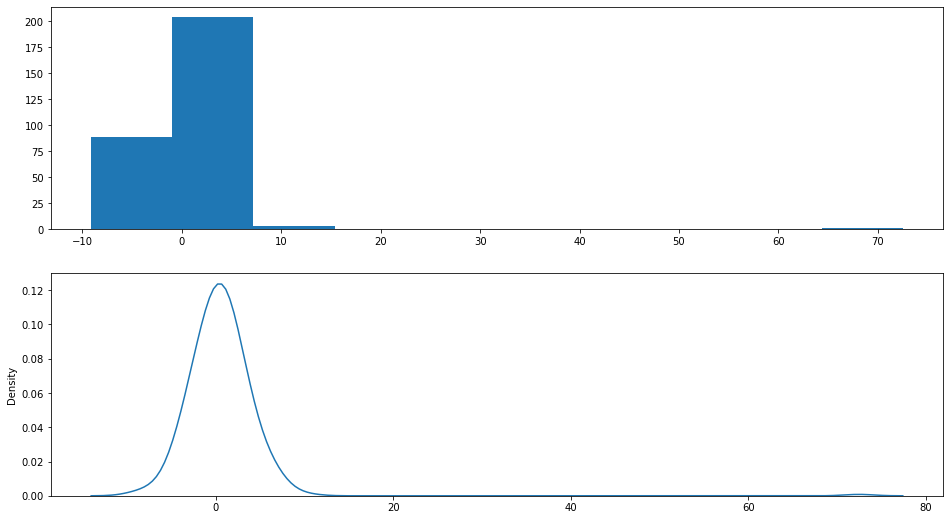

In [30]:
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.hist(model_Fitted.resid)
plt.subplot(212)
sns.kdeplot(model_Fitted.resid)
plt.show()

In [31]:
test.shape[0]

100

In [32]:
predicoes = model_Fitted.predict(start= test.index[0], end = test.index[test.shape[0]-1]);

In [33]:
predicoesDf = pd.DataFrame(predicoes)
predicoesDf['Real'] = test['Producao']
predicoesDf.head()

,predicted_mean,Real
2009-10-01,87.347783,89.2977
2009-11-01,90.064701,89.3585
2009-12-01,100.972107,110.6844
2010-01-01,109.101410,119.0166
2010-02-01,106.772648,110.5330


<AxesSubplot:>

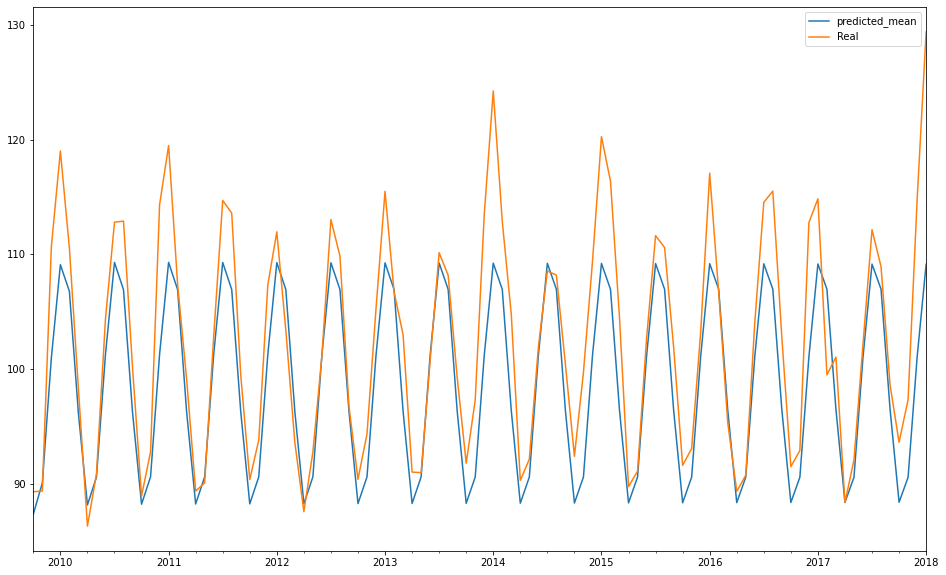

In [34]:
predicoesDf.plot()

In [35]:
mean_squared_error(predicoesDf.Real, predicoesDf.predicted_mean)

31.64780190547791

In [36]:
def testaParams(paramP = [1,2,3,4,5,6,7,8], paramD = [1,2], paramQ = [1,2,3,4,5,6,7,8], treino = 0, teste = 0):
    model = ARIMA(train['Producao'], order = (4,1,4), freq = 'MS')
    modelFit = model.fit()
    predicoes = modelFit.predict(start= test.index[0], end = test.index[test.shape[0]-1]);
    rmseInicial = mean_squared_error(test['Producao'],predicoes)
    
    melhorRMSE = rmseInicial
    melhorP, melhorD, melhorQ = 0,0,0
    
    for P in paramP:
        for D in paramD:
            for Q in paramQ:
                model = ARIMA(train['Producao'], order = (P,D,Q), freq = 'MS')
                modelFit = model.fit()
                predicoes = modelFit.predict(start= test.index[0], end = test.index[test.shape[0]-1]);
                rmse = mean_squared_error(test['Producao'], predicoes)
                if rmse < rmseInicial:
                    melhorRMSE = rmse
                    melhorP = P
                    melhorD = D
                    melhorQ = Q
                    
                    
    
    return(melhorP, melhorD, melhorQ)
    
    
testaParams()

(8, 2, 8)

In [43]:
modelAR = ARIMA(train['Producao'], order = (8,2,8), freq = 'MS')
model_Fitted = modelAR.fit()
predicoes = model_Fitted.predict(start= test.index[0], end = test.index[test.shape[0]-1]);
np.sqrt(mean_squared_error(test['Producao'], predicoes))

4.730859665942047

In [38]:
test['Producao'].values

array([ 89.2977,  89.3585, 110.6844, 119.0166, 110.533 ,  98.2672,
        86.3   ,  90.8364, 104.3538, 112.8066, 112.9014, 100.1209,
        88.9251,  92.775 , 114.3266, 119.488 , 107.3753,  99.1028,
        89.3583,  90.0698, 102.8204, 114.7068, 113.5958,  99.4712,
        90.3566,  93.8095, 107.3312, 111.9646, 103.3679,  93.5772,
        87.5566,  92.7603, 101.14  , 113.0357, 109.8601,  96.7431,
        90.3805,  94.3417, 105.2722, 115.501 , 106.734 , 102.9948,
        91.0092,  90.9634, 100.6957, 110.148 , 108.1756,  99.2809,
        91.7871,  97.2853, 113.4732, 124.2549, 112.8811, 104.7631,
        90.2867,  92.134 , 101.878 , 108.5497, 108.194 , 100.4172,
        92.3837,  99.7033, 109.3477, 120.2696, 116.3788, 104.4706,
        89.7461,  91.093 , 102.6495, 111.6354, 110.5925, 101.9204,
        91.5959,  93.0628, 103.2203, 117.0837, 106.6688,  95.3548,
        89.3254,  90.7369, 104.0375, 114.5397, 115.5159, 102.7637,
        91.4867,  92.89  , 112.7694, 114.8505,  99.4901, 101.0

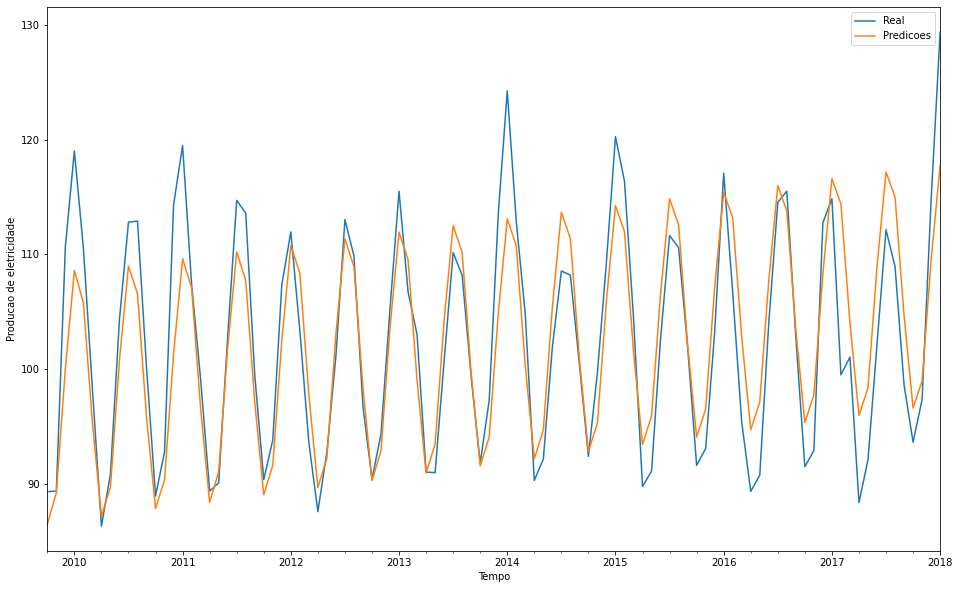

In [39]:
dfWithPredictions = pd.DataFrame({'Real':test['Producao'].values,'Predicoes':predicoes}, index = test.index)

dfWithPredictions.plot()
plt.xlabel('Tempo')
plt.ylabel('Producao de eletricidade')
plt.show()

In [40]:
dfWithPredictions

,Real,Predicoes
data,,
2009-10-01,89.2977,86.436880
2009-11-01,89.3585,89.226292
2009-12-01,110.6844,100.020964
2010-01-01,119.0166,108.600808
2010-02-01,110.5330,105.762466
...,...,...
2017-09-01,98.6154,104.657809
2017-10-01,93.6137,96.590252
2017-11-01,97.3359,98.959786


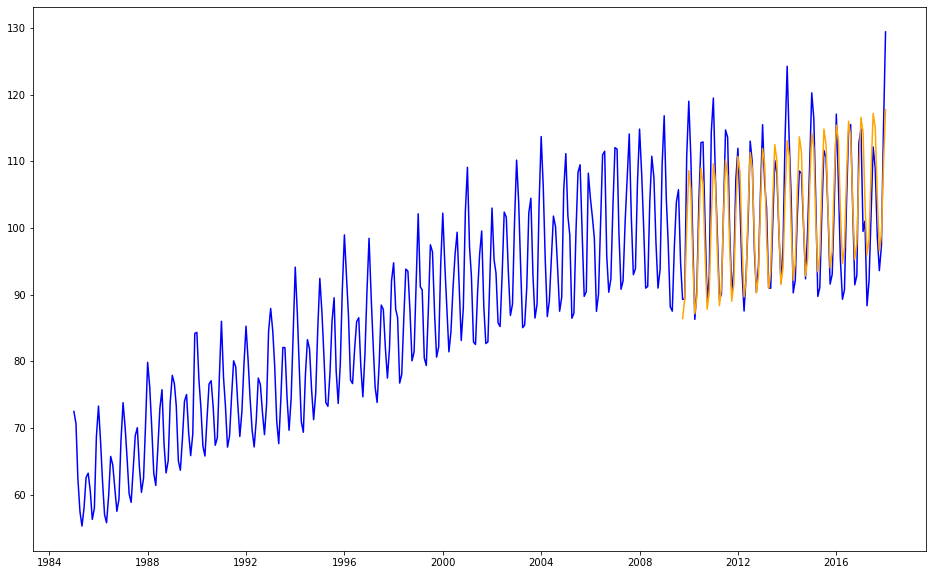

In [41]:
plt.plot(dfTimeSerie['Producao'], color = 'blue', label = 'Real')
plt.plot(dfWithPredictions['Predicoes'], color = 'orange', label = 'Predicoes')
